In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd
#import earthpy as et
import xarray as xr

import cartopy.feature as cf
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mticker
import cartopy.feature as cf
from cartopy.util import add_cyclic_point

# Plotting options
sns.set(font_scale=1.3)
sns.set_style("white")

## Load storm surge and tidal data: 

### Water level change indicators for the European coast from 1977 to 2100 derived from climate projections
https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-water-level-change-indicators?tab=overview

Statistics for `historical` ERA5 reanalysis: from 1979 to 2005

* `Annual mean highest high water level` : what Climate Central uses 

* `Highest astronomical tide` : more similar to what BRGM uses

* `Surge level` : storm surge for different return periods

* `Tidal range`

* `Total water level` : storm surge and tidal contributions

Other sources : 
* Select values geographically:
https://cds.climate.copernicus.eu/cdsapp#!/software/app-coastal-indicators-waves-projections?tab=app


* BRGM tool: https://sealevelrise.brgm.fr/slr/#lng=-2.06337;lat=47.24195;zoom=11;level=1.0;layer=0

* Plot shapefile with xarray: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/fundamentals-raster-data/open-lidar-raster-python-xarray/




In [2]:
folder_path = '/Users/annalea_albright/Dropbox/BPCE/Data/storm_surge/'

# 2 year return period, variable return_surge_level
df_hist_2 = xr.open_dataset(os.path.join(folder_path, 'historical-RPS-rp2-v0.0.nc'))

# 5 year return period
df_hist_5 = xr.open_dataset(os.path.join(folder_path, 'historical-RPS-rp5-v0.0.nc'))

# 100 year return period, in case we are wrong about stationarity
df_hist_100 = xr.open_dataset(os.path.join(folder_path, 'historical-RPS-rp100-v0.0.nc'))

# Highest astronomical tide,  variable HAT
# this is the variable that we want!
df_tides = xr.open_dataset('/Users/annalea_albright/Dropbox/BPCE/Data/tides/historical-HAT-v0.0.nc')

# Annual mean highest high water level
# time resolved values
df_tides_AMHHW = xr.open_dataset('/Users/annalea_albright/Dropbox/BPCE/Data/tides/historical-AMHHW-v0.0.nc')

# tidal range, old, not the variable we want ... referenced to low tide level ("Zero hydrographique")
#df_tidal_range = xr.open_dataset('/Users/annalea_albright/Dropbox/BPCE/Data/tides/historical-tidal_range-v0.0.nc')

print(df_hist_2.summary)
print(df_hist_2.variables.values)
print('\n')
print(df_tides.summary)
print(df_tides.variables.values)

Dataset with return values for surge. Produced with the Global Tide and Surge Model (GTSM) version 3.0 forced with winds and sea surface pressure from EC-EARTH_DMI-HIRHAM5 dataset for period 1977_2005. Return periods are based on fitting a Gumbel distribution to the annual maxima
<bound method Mapping.values of Frozen({'station_x_coordinate': <xarray.Variable (stations: 23256)>
[23256 values with dtype=float64]
Attributes:
    long_name:   longitude
    short_name:  longitude, 'station_y_coordinate': <xarray.Variable (stations: 23256)>
[23256 values with dtype=float64]
Attributes:
    long_name:   latitude
    short_name:  latitude, 'return_surge_level': <xarray.Variable (stations: 23256)>
[23256 values with dtype=float64]
Attributes:
    units:       m
    long_name:   Return surge level for 2 year return period
    short_name:  return_levels})>


 Tidal indicators produced with the Global Tide and Surge Model (GTSM) version 3.0 for period 1977_2005
<bound method Mapping.values of Fro

## Highest astronomical tide definition and vertical datums

The Highest Astronomical Tide (HAT) Line is a term used in coastal engineering and tide prediction to represent the highest level that the ocean's surface can reach under the influence of astronomical factors alone, disregarding any additional effects such as storm surges. It is an extreme high tide level used as a reference for various purposes, such as determining flood risk zones, designing coastal infrastructure, and establishing tidal datums.

Tide and storm surge data : “The vertical reference of the model is mean sea level, given that the bathymetric data is referenced to that vertical datum.” https://confluence.ecmwf.int/display/CKB/Product+user+guide+for+sea+level+and+ocean+wave+products+-+time+series+and+indicators 


In [3]:
df_hist_2

<xarray.Dataset>
Dimensions:               (stations: 23256)
Coordinates:
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
Dimensions without coordinates: stations
Data variables:
    return_surge_level    (stations) float64 ...
Attributes:
    geospatial_lon_min:   150
    source:               GTSMv3.0 (D-FLOW FM) forced with EC-EARTH_DMI-HIRHAM5
    geospatial_lat_max:   72.5
    contact:              c3s422.support@deltares.nl
    time_coverage_start:  
    licence:              
    time_coverage_end:    
    geospatial_lat_min:   25
    geospatial_lon_max:   225
    summary:              Dataset with return values for surge. Produced with...

In [151]:
df_tides_AMHHW["AMHHW"].sel

<bound method DataArray.sel of <xarray.DataArray 'AMHHW' (time: 29, stations: 23256)>
[674424 values with dtype=float64]
Coordinates:
  * stations              (stations) |S40 b'id_coast_glob_eur_00001' ... b'is...
    station_x_coordinate  (stations) float64 ...
    station_y_coordinate  (stations) float64 ...
  * time                  (time) datetime64[ns] 1977-01-01 ... 2005-01-01
Attributes:
    long_name:   Annual_tidal_mean_high_high_water_including_annual_mean_sea_...
    units:       m
    short_name:  annual_mean_highwater>

355.861816
52.33154


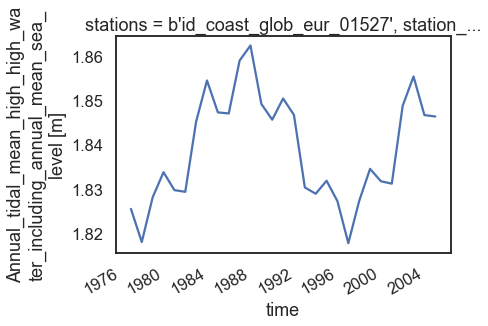

In [152]:
sel_num = 1500
df_tides_AMHHW["AMHHW"].isel(stations=sel_num).plot()
print(df_tides_AMHHW["AMHHW"].isel(stations=sel_num).station_x_coordinate.values)
print(df_tides_AMHHW["AMHHW"].isel(stations=sel_num).station_y_coordinate.values)

### Different longitude values for the tides in some cases

In [153]:
print(df_tides.station_x_coordinate.values)

print(df_hist_2.station_x_coordinate.values)

[ 24.08936   24.08936   26.90186  ... 336.708984 343.798828   9.250488]
[384.08936  384.08936  386.90186  ... 336.708984 343.798828 369.250488]


In [154]:
df_tides['station_x_coordinate'] = df_hist_2['station_x_coordinate'] 

In [155]:
print(df_tides.station_x_coordinate.min().values)
print(df_tides.station_x_coordinate.max().values)

330.01465
404.94141


## Load shapefile for `regions` of France

In [4]:
fp_shape = '/Users/annalea_albright/Dropbox/BPCE/Data/regions_shapefile/FRA_adm1.shp'
regions_gdf = gpd.read_file(fp_shape)
print('# of regions', len(regions_gdf.NAME_1.values))
print(regions_gdf.NAME_1.values, '\n')
print(regions_gdf.columns)
#print(regions_gdf.head())

# of regions 22
['Alsace' 'Aquitaine' 'Auvergne' 'Île-de-France' 'Basse-Normandie'
 'Bourgogne' 'Bretagne' 'Centre' 'Champagne-Ardenne' 'Corse'
 'Franche-Comté' 'Haute-Normandie' 'Languedoc-Roussillon' 'Limousin'
 'Lorraine' 'Midi-Pyrénées' 'Nord-Pas-de-Calais' 'Pays de la Loire'
 'Picardie' 'Poitou-Charentes' "Provence-Alpes-Côte d'Azur" 'Rhône-Alpes'] 

Index(['ID_0', 'ISO', 'NAME_0', 'ID_1', 'NAME_1', 'HASC_1', 'CCN_1', 'CCA_1',
       'TYPE_1', 'ENGTYPE_1', 'NL_NAME_1', 'VARNAME_1', 'geometry'],
      dtype='object')


In [5]:
gdf = regions_gdf
region = 'Aquitaine' # Picardie, Aquitaine

# aoi: area of interest
PL_aoi = gdf[gdf.NAME_1 == region]
aoi_lat = [float(PL_aoi.total_bounds[1]), float(PL_aoi.total_bounds[3])]
aoi_lon = [float(PL_aoi.total_bounds[0]), float(PL_aoi.total_bounds[2])]

print(f'longitude bounds for {region}', aoi_lon)
print(f'longitude bounds, adjusted for {region}', [val + 360 for val in aoi_lon])

longitude bounds for Aquitaine [-1.788472056388855, 1.448261499405021]
longitude bounds, adjusted for Aquitaine [358.21152794361115, 361.448261499405]


### Some other info
first level administrative France, regions : https://geodata.lib.berkeley.edu/catalog/stanford-ym781wr7170  or communes https://geodata.lib.berkeley.edu/catalog/stanford-fq136pf8502  France shapefile https://www.eea.europa.eu/data-and-maps/data/eea-reference-grids-2/gis-files/france-shapefile 

## For `Departments` : do this later, at finer spatial scale, e.g., it matters for Bretagne

In [208]:
# Source to download : https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/

fp_shape = '/Users/annalea_albright/Dropbox/BPCE/Data/departements-20180101-shp/departements-20180101.shp'
dept_gdf = gpd.read_file(fp_shape)
print(dept_gdf.columns, '\n')
#print(dept_gdf.head())
print(dept_gdf.code_insee.head(), '\n')
print(dept_gdf.nom.head())

# https://www.cartesfrance.fr/carte-france-departement/carte-france-departements.html

Index(['code_insee', 'nom', 'nuts3', 'wikipedia', 'surf_km2', 'geometry'], dtype='object') 

0    974
1     11
2     43
3     13
4     47
Name: code_insee, dtype: object 

0          La Réunion
1                Aude
2         Haute-Loire
3    Bouches-du-Rhône
4      Lot-et-Garonne
Name: nom, dtype: object


In [197]:
dept_num = 29 #62 # Pas de Calais
dept_name = dept_gdf["nom"][dept_gdf.code_insee == str(dept_num)].values

# aoi: area of interest
PL_aoi = dept_gdf[dept_gdf.code_insee == str(dept_num)]
aoi_lat = [float(PL_aoi.total_bounds[1]), float(PL_aoi.total_bounds[3])]
aoi_lon = [float(PL_aoi.total_bounds[0]), float(PL_aoi.total_bounds[2])]

print(f'longitude bounds for {dept_name}', aoi_lon)
print(f'longitude bounds, adjusted for {dept_name}', [val + 360 for val in aoi_lon])

longitude bounds for ['Finistère'] [-5.141276481967004, -3.386654639842998]
longitude bounds, adjusted for ['Finistère'] [354.858723518033, 356.613345360157]


In [203]:
French_dept_coast = [59, 62, 80, 76, 14, 50, 35, 
22, 29, 56, 44, 85, 17, 33, 
40, 64, 66, 11, 34, 30, 
83, 6]

French_dept_coast_str = [str(dept) for dept in French_dept_coast]
print(len(French_dept_coast_str))

23


In [207]:
# Select rows based on the values in the "Name" column
dept_gdf_selected_rows = dept_gdf[dept_gdf['code_insee'].isin(French_dept_coast_str)]

# Print the selected rows
print(dept_gdf_selected_rows)

    code_insee                   nom  nuts3                  wikipedia  \
1           11                  Aude  FR811      fr:Aude (département)   
9           76        Seine-Maritime  FR232          fr:Seine-Maritime   
18          34               Hérault  FR813   fr:Hérault (département)   
19          62         Pas-de-Calais  FR302           fr:Pas-de-Calais   
20          80                 Somme  FR223     fr:Somme (département)   
23          12               Aveyron  FR622   fr:Aveyron (département)   
24          40                Landes  FR613    fr:Landes (département)   
25          64  Pyrénées-Atlantiques  FR615    fr:Pyrénées-Atlantiques   
26          66   Pyrénées-Orientales  FR815     fr:Pyrénées-Orientales   
28          33               Gironde  FR612   fr:Gironde (département)   
30          85                Vendée  FR515    fr:Vendée (département)   
49          59                  Nord  FR301      fr:Nord (département)   
50          22         Côtes-d'Armor  

# Define functions for compositing by `Region`
This is imperfect because it selects regions using a rectangle, instead of a shapefile. But given that the data do not have coordinates lat x lon, and rather are 1D by `station`, I did not see how to do it otherwise.

As a result, there is some slight overlap between the regions. It would lead to large mistakes if doing using overlapping rectangles later when subtracting tidal, storm surge, etc values region by region, but for averaging tides over a larger area, we accept this overlap and error that is introduced.

A goal later on is to add tidal data for finer spatial scales.

In [17]:
def plot_map(
            df,
            var,
    vmin,
    vmax,
            label,
            title,
    cmap_sel="cool",
                ):
    
    sns.set_context("talk")
    sns.set_style("white")

    fig,ax = plt.subplots(
        figsize=(10,15),
        subplot_kw={'projection':ccrs.PlateCarree()},

    )

    ax.coastlines(resolution='10m')
    ax.add_feature(cf.BORDERS)
    lon_left, lon_right = -5, 7.8
    lat_S, lat_N = 42, 51.5
    ax.set_extent([lon_left, lon_right, lat_S, lat_N])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    gl = ax.gridlines(color='Grey',draw_labels=True, alpha=0.5, linestyle='--')
    gl_space = 4
    gl.xlocator = mticker.FixedLocator(np.arange(lon_left-gl_space, lon_right+gl_space, gl_space))
    gl.ylocator = mticker.FixedLocator(np.arange(lat_S-gl_space, lat_N+gl_space, gl_space))
    fs = 15
    gl.xlabel_style = {'size': fs}
    gl.ylabel_style = {'size': fs}

    df = pd.DataFrame({
        'lon': df.station_x_coordinate.values,
        'lat': df.station_y_coordinate.values, 
        'var': df[var].values   # return_water_level

    })
    sc = ax.scatter(
        df['lon'],
        df['lat'],
        c=df['var'],
        cmap=cmap_sel, #"cool", #plasma , seismic, GnBu, plasma_r
        s=30,
        vmin =vmin, 
     vmax = vmax,
               )
    #import matplotlib as mpl
    cbar = fig.colorbar(sc,
                       fraction=0.04,
                anchor=(-1,0.5),
                        #norm=mpl.colors.Normalize(vmin=0.5, vmax=1)
                       )

    cbar.set_label(
        label=label,
       # "log of historical storm surge, \n 2 yr return period (m)",  # log of 
                   labelpad=5
                  )
    
    import matplotlib.patches as patches

    # Create a Rectangle patch
    rect = patches.Rectangle((df['lon'].min(), df['lat'].max()), abs(df['lon'].max() - df['lon'].min()), 
                             df['lat'].max() - df['lat'].min(), linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
        
    plt.title(title)
    ax.axis('off')
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    plt.box(on=None)

In [18]:
def calc_mean_variable_per_region(
    df, # for tides and storm surge
    gdf, # geopandas dataframe for the shapefile (e.g. the region)
    region, # name of the region
    var, # variable : HAT for tides and return_water_level for the storm surge
    plot_true,
    vmin, # for the colorbar, min and max
    vmax,
):
    # area of interest
    PL_aoi = gdf[gdf.NAME_1 == region]
    aoi_lat = [float(PL_aoi.total_bounds[1]), float(PL_aoi.total_bounds[3])]
    aoi_lon = [float(PL_aoi.total_bounds[0]), float(PL_aoi.total_bounds[2])]
    
    # shapefile goes -180 to 180
    # vs. storm surge and tide data goes 330-400
    aoi_lon[0] = aoi_lon[0] + 360
    aoi_lon[1] = aoi_lon[1] + 360
  
    # reformat xarray Dataset (including tide or storm surge data)
    test = df.swap_dims({'stations': 'station_x_coordinate'})
    test = test.sortby("station_x_coordinate")
    test = test.sel(
        station_x_coordinate=slice(aoi_lon[0], aoi_lon[1]),
    )
    test2 = test.where((test.station_y_coordinate >= aoi_lat[0]) & (test.station_y_coordinate <= aoi_lat[1]), 
                       drop=True)
    
    if plot_true:
        plot_map(
            df=test2,
            var=var,
        vmin=vmin,
        vmax=vmax,
            label="m",
            title=region,
                )
        
        

    if plot_true:
        plt.figure(figsize=(7,5))
        var_sel = test2[var].values
        sns.kdeplot(var_sel, color="black")
        var_round=np.round(np.mean(var_sel), 2)
        plt.axvline(np.mean(test2[var].values), 
                    color="grey",
                   label=f"mean value: {var_round}",
                   )
        plt.legend(loc="upper right")
        if var=="return_surge_level":
            plt.xlabel(f'surcote, période de retour 2 ans (m)')
        else:
            plt.xlabel(f'marnage (m)')    
            
        sns.despine()
        plt.title(f"{region}")
        
    vec_save = [aoi_lat, aoi_lon, np.nanmean(test2[var].values)]
    
    return vec_save
    

## Look at one example

[[49.970657348632926, 51.08939743041998], [361.5552779436112, 364.230134010315], 1.7008450456195845]


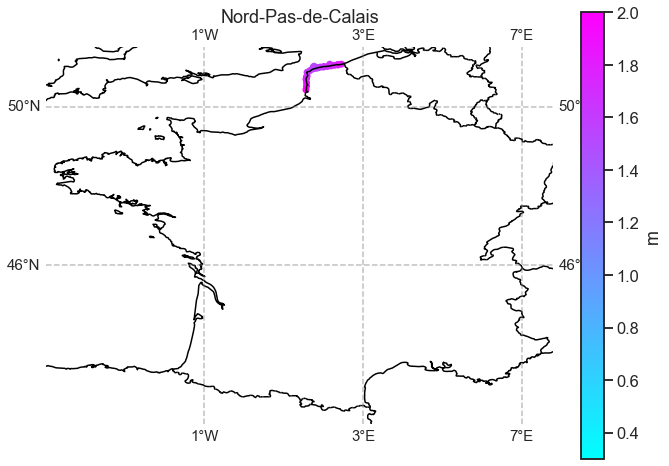

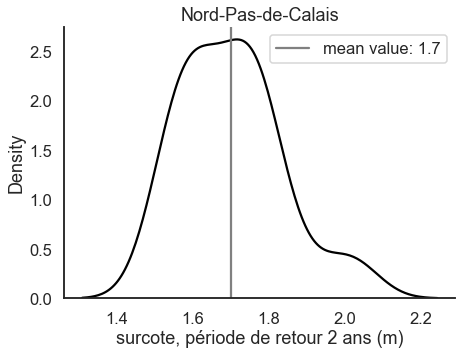

In [19]:
vec_save_example = calc_mean_variable_per_region(
    df=df_hist_2,
    gdf=regions_gdf,
    region="Nord-Pas-de-Calais", #"Nord-Pas-de-Calais", # Nord-Pas-de-Calais, Basse-Normandie
    var="return_surge_level",
    plot_true=1,
    vmin=0.3,
    vmax=2,
)
print(vec_save_example) 
# [aoi_lat, aoi_lon, np.mean(test2[var].values)]


### Example for highest astronomical tide, HAT

[[45.08924865722656, 47.17575836181646], [358.4368050098419, 361.21306586265575], 2.9218735665444857]


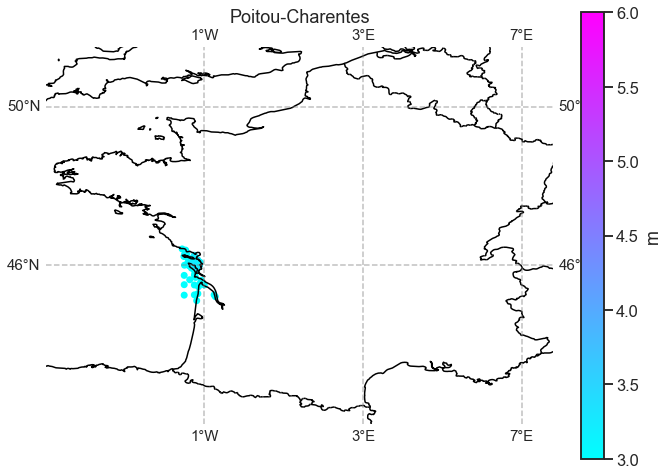

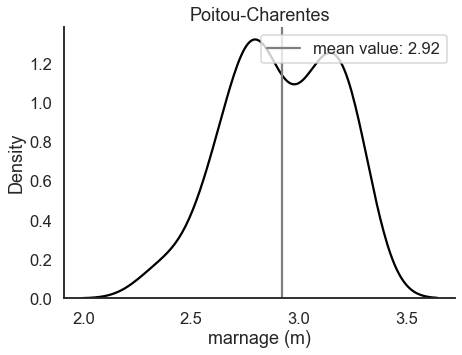

In [23]:
vec_save_example_tides = calc_mean_variable_per_region(
    df=df_tides,
    gdf=regions_gdf,
    region="Poitou-Charentes", #"Nord-Pas-de-Calais", Picardie, Bretagne, Aquitaine
    
    #['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie', 'Basse-Normandie',
    #'Bretagne', 'Pays de la Loire', 'Poitou-Charentes', 'Aquitaine', 'Languedoc-Roussillon',
    # "Provence-Alpes-Côte d'Azur"]
    
    var="HAT", 
    plot_true=1,
    vmin=3,
    vmax=6,
#     vmin=2,
#      vmax=3.5,
)
print(vec_save_example_tides)

## Have 4 broad geographical zones, for reference (data are, however, added at a finer geographic scale)

In [15]:
zone1 = ['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie', 'Basse-Normandie']
zone2 = ['Bretagne', 'Pays de la Loire', 'Poitou-Charentes']
zone3 = ['Aquitaine']
zone4 = ['Languedoc-Roussillon', "Provence-Alpes-Côte d'Azur"]

zones_coast = zone1 + zone2 + zone3 + zone4
print(zones_coast)

['Nord-Pas-de-Calais', 'Picardie', 'Haute-Normandie', 'Basse-Normandie', 'Bretagne', 'Pays de la Loire', 'Poitou-Charentes', 'Aquitaine', 'Languedoc-Roussillon', "Provence-Alpes-Côte d'Azur"]


In [106]:
def calc_mean_across_zone(zone, 
                          df_sel=df_hist_2, 
                          var_sel = "return_surge_level"
                         ):
    
    storm_surge_zone = []
        
    # Example with 2 year return period
    for region in zone:
        print(region)
        storm_surge_zone.append(
        calc_mean_variable_per_region(
        df=df_sel,
        gdf=regions_gdf,
        region=region,
            var=var_sel, #"return_surge_level",
        plot_true=0,
            vmin=None,
            vmax=None,
    )[2] # 0 is lat, 1 is lon bounds
        )
          
    #print('mean for each region', storm_surge_zone)
    mean_zone = np.mean(storm_surge_zone)
    print('mean across zone', mean_zone)
    return mean_zone

In [107]:
print('mean for 2 year return period storm surge')

mean_zone1 = calc_mean_across_zone(zone1)
mean_zone2 = calc_mean_across_zone(zone2)
mean_zone3 = calc_mean_across_zone(zone3)
mean_zone4 = calc_mean_across_zone(zone4)

mean for 2 year return period storm surge
Nord-Pas-de-Calais
Picardie
Haute-Normandie
Basse-Normandie
mean across zone 1.6801261542107282
Bretagne
Pays de la Loire
Poitou-Charentes
mean across zone 0.9076705877321847
Aquitaine
mean across zone 0.5859836380647248
Languedoc-Roussillon
Provence-Alpes-Côte d'Azur
mean across zone 0.37257688904819214


In [158]:
print('mean for highest astronomical tide')
mean_zone1 = calc_mean_across_zone(zone1, df_sel=df_tides, var_sel="HAT")
mean_zone2 = calc_mean_across_zone(zone2, df_sel=df_tides, var_sel="HAT")
mean_zone3 = calc_mean_across_zone(zone3, df_sel=df_tides, var_sel="HAT")
mean_zone4 = calc_mean_across_zone(zone4, df_sel=df_tides, var_sel="HAT")

mean for highest astronomical tide
Nord-Pas-de-Calais
Picardie
Haute-Normandie
Basse-Normandie
mean across zone 4.947169996205942
Bretagne
Pays de la Loire
Poitou-Charentes
mean across zone 3.3295820066020916
Aquitaine
mean across zone 2.5393862689948916
Languedoc-Roussillon
Provence-Alpes-Côte d'Azur
mean across zone 0.1678610378952266


In [159]:
def create_df_regions_var(
    df,
    var,
):
    
    d = []
    for region in zones_coast:

            aoi_lat, aoi_lon, var_mean = calc_mean_variable_per_region(
            df,
            gdf=regions_gdf,
            region=region,
                var=var,
            plot_true=0,
                vmin=None,
                vmax=None,
                            )

            d.append(
            {
                'Region': region,
                'lat_min': aoi_lat[0],
                'lat_max': aoi_lat[1],
                'lon_min': aoi_lon[0],
                'lon_max': aoi_lon[1],
                'var_mean': var_mean,
            }
        )
    
    return pd.DataFrame(d)


In [137]:
df_2_surge = create_df_regions_var(
    df=df_hist_2,
    var="return_surge_level",
)
print(df_2_surge)

folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'
df_2_surge.to_csv(os.path.join(folder_save, 'df_pd_2year_surge.csv'))

                       Region    lat_min    lat_max     lon_min     lon_max  \
0          Nord-Pas-de-Calais  49.970657  51.089397  361.555278  364.230134   
1                    Picardie  48.838474  50.368549  361.379723  364.255734   
2             Haute-Normandie  48.666523  50.071552  360.065138  361.802660   
3             Basse-Normandie  48.180092  49.728195  357.935972  360.976416   
4                    Bretagne  47.278751  49.105694  354.856249  358.981797   
5            Pays de la Loire  46.266804  48.568001  357.373472  360.916650   
6            Poitou-Charentes  45.089249  47.175758  358.436805  361.213066   
7                   Aquitaine  42.777672  45.714569  358.211528  361.448261   
8        Languedoc-Roussillon  42.333443  44.975723  361.688420  364.845344   
9  Provence-Alpes-Côte d'Azur  42.981529  45.126846  364.229758  367.716127   

   var_mean  
0  1.700845  
1  2.091533  
2  1.551201  
3  1.376926  
4  0.936830  
5  0.918620  
6  0.867562  
7  0.585984  
8  0

In [138]:
df_5_surge = create_df_regions_var(
    df=df_hist_5,
    var="return_surge_level",
)
print(df_5_surge)

folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'
df_5_surge.to_csv(os.path.join(folder_save, 'df_pd_5year_surge.csv'))

                       Region    lat_min    lat_max     lon_min     lon_max  \
0          Nord-Pas-de-Calais  49.970657  51.089397  361.555278  364.230134   
1                    Picardie  48.838474  50.368549  361.379723  364.255734   
2             Haute-Normandie  48.666523  50.071552  360.065138  361.802660   
3             Basse-Normandie  48.180092  49.728195  357.935972  360.976416   
4                    Bretagne  47.278751  49.105694  354.856249  358.981797   
5            Pays de la Loire  46.266804  48.568001  357.373472  360.916650   
6            Poitou-Charentes  45.089249  47.175758  358.436805  361.213066   
7                   Aquitaine  42.777672  45.714569  358.211528  361.448261   
8        Languedoc-Roussillon  42.333443  44.975723  361.688420  364.845344   
9  Provence-Alpes-Côte d'Azur  42.981529  45.126846  364.229758  367.716127   

   var_mean  
0  2.029895  
1  2.516114  
2  1.871473  
3  1.635894  
4  1.093321  
5  1.088803  
6  1.027152  
7  0.685805  
8  0

In [146]:
df_100_surge = create_df_regions_var(
    df=df_hist_100,
    var="return_surge_level",
)
print(df_100_surge)

folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'
df_100_surge.to_csv(os.path.join(folder_save, 'df_pd_100year_surge.csv'))

                       Region    lat_min    lat_max     lon_min     lon_max  \
0          Nord-Pas-de-Calais  49.970657  51.089397  361.555278  364.230134   
1                    Picardie  48.838474  50.368549  361.379723  364.255734   
2             Haute-Normandie  48.666523  50.071552  360.065138  361.802660   
3             Basse-Normandie  48.180092  49.728195  357.935972  360.976416   
4                    Bretagne  47.278751  49.105694  354.856249  358.981797   
5            Pays de la Loire  46.266804  48.568001  357.373472  360.916650   
6            Poitou-Charentes  45.089249  47.175758  358.436805  361.213066   
7                   Aquitaine  42.777672  45.714569  358.211528  361.448261   
8        Languedoc-Roussillon  42.333443  44.975723  361.688420  364.845344   
9  Provence-Alpes-Côte d'Azur  42.981529  45.126846  364.229758  367.716127   

   var_mean  
0  2.929928  
1  3.677451  
2  2.747497  
3  2.344237  
4  1.521365  
5  1.554297  
6  1.463674  
7  0.958842  
8  0

In [162]:
df_pd_tides = create_df_regions_var(
    df=df_tides,
    var="HAT", #tidal_range
)
print(df_pd_tides)

folder_save = '/Users/annalea_albright/Dropbox/BPCE/Data/'
df_pd_tides.to_csv(os.path.join(folder_save, 'df_pd_tides.csv'))

                       Region    lat_min    lat_max     lon_min     lon_max  \
0          Nord-Pas-de-Calais  49.970657  51.089397  361.555278  364.230134   
1                    Picardie  48.838474  50.368549  361.379723  364.255734   
2             Haute-Normandie  48.666523  50.071552  360.065138  361.802660   
3             Basse-Normandie  48.180092  49.728195  357.935972  360.976416   
4                    Bretagne  47.278751  49.105694  354.856249  358.981797   
5            Pays de la Loire  46.266804  48.568001  357.373472  360.916650   
6            Poitou-Charentes  45.089249  47.175758  358.436805  361.213066   
7                   Aquitaine  42.777672  45.714569  358.211528  361.448261   
8        Languedoc-Roussillon  42.333443  44.975723  361.688420  364.845344   
9  Provence-Alpes-Côte d'Azur  42.981529  45.126846  364.229758  367.716127   

   var_mean  
0  4.376885  
1  5.880680  
2  4.764923  
3  4.766192  
4  4.239764  
5  2.827109  
6  2.921874  
7  2.539386  
8  0

# Other approach of tides from SHOM. 

## But here the vertical reference is different, it is based on IGN69 and requires a conversion from these SHOM data to IGN69 reference frame

In [229]:
# Load the Excel file into a DataFrame

# Downloaded the data here : https://www.geocatalogue.fr/Detail.do?fileIdentifier=MAREE_COURANTS_RAM.xml

fp_xlsx = '/Users/annalea_albright/Dropbox/BPCE/Data/tides_France_PHMA_ZH_Ref.xlsx'
df = pd.read_excel(fp_xlsx)

# Filter the DataFrame for latitudes within the range of 40 to 55
df = df[(df['LATITUDE'] >= 40) & (df['LATITUDE'] <= 55)]

df.head(10)

,SITE,ZONE,TYPE_PORT,LATITUDE,LONGITUDE,ET,DATE_CH,PHMA,PMVE,PMME,...,BMVE,PBMA,RF,ORGANISME,DATE_RF,RF_ZH,RF_Ref,ZH_Ref,ZH_Elli,REFERENCE
0,Dunkerque,Abords de Dunkerque,R,51.048056,2.366667,12.16,NaN,6.48,6.05,5.00,...,0.60,-0.01,N.A.L3 - 7,IGN,2013.0,9.504,6.811,-2.693,40.860,IGN69
1,Banc du Sandettié,Abords de Dunkerque,S,51.250000,2.050000,11.95,NaN,5.81,5.40,4.45,...,0.55,-0.02,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Dunkerque Ouest,Abords de Dunkerque,S,51.022500,2.180833,11.97,NaN,6.88,6.40,5.30,...,0.60,-0.04,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gravelines,Abords de Dunkerque,S,51.016667,2.100000,11.94,NaN,6.96,6.50,5.35,...,0.65,0.05,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Calais,Abords de Calais,R,50.969333,1.867500,11.76,2010.0,7.90,7.30,6.05,...,0.80,0.19,N.A.L3-159,IGN,2016.0,9.418,5.959,-3.459,40.007,IGN69
5,Wissant,Abords de Calais,S,50.883333,1.666667,11.53,NaN,8.62,8.00,6.60,...,1.00,0.39,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Ruytingen,Abords de Calais,S,51.082481,1.780336,11.82,NaN,7.09,6.60,5.50,...,0.85,0.28,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Boulogne-sur-Mer,Abords de Boulogne-sur-Mer,R,50.727450,1.577700,11.36,2017.0,9.67,9.00,7.30,...,1.15,0.39,N.BC-3 BIS,IGN,2016.0,12.867,8.485,-4.382,39.360,IGN69
8,Banc du Vergoyer,Abords de Boulogne-sur-Mer,S,50.594129,1.330340,11.15,NaN,9.55,8.90,7.20,...,1.05,0.33,pas de rattachement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Le Touquet-Étaples,Abords de Boulogne-sur-Mer,S,50.515300,1.561000,11.10,2012.0,10.14,9.45,7.60,...,1.15,0.36,N.C.L3-52,IGN,1982.0,14.580,10.135,-4.445,40.667,IGN69


In [230]:
# Calculate the difference between the columns PHMA and ZH_REF
df['Difference'] = df['PHMA'] + df['ZH_Ref'] # ZH_ref is negative
 
print(df['Difference'])

# Filter the DataFrame for the site named "Calais"
calais_data = df[df['SITE'] == 'Calais']

# Get the value of the Difference for the site named "Calais"
difference_value = calais_data['Difference'].values[0]

# Print the result
print("Difference value for Calais:", difference_value)

# Calais
# Dans ce même document vous avez les conversions dans les tableaux en regardant ZH/Ref
# Par exemple sur Calais : PHMA= 7,89 ; ZH/REF =-3,455 donc le niveau PHMA en altimétrie IGN69
# est de 7,89-3,455=4,435mIGN69

0      3.787
1        NaN
2        NaN
3        NaN
4      4.441
       ...  
226    0.355
227      NaN
228    0.338
229    1.335
230    1.285
Name: Difference, Length: 231, dtype: float64
Difference value for Calais: 4.441000000000001


In [233]:
# Calculate the difference between the columns PHMA and ZH_REF
df['Difference'] = df['PHMA'] + df['ZH_Ref'] # ZH_ref is negative

# Group the data by the ZONE column and calculate the nanmean of the differences
grouped_data = df.groupby('ZONE')['Difference'].apply(np.nanmean)

# Print the result
print(grouped_data)
print(len(grouped_data))

ZONE
Abords d'Arcachon et de Cap Breton    2.730667
Abords de Boulogne-sur-Mer            5.491500
Abords de Calais                      4.441000
Abords de Cherbourg et du Havre       4.045143
Abords de Dieppe                      5.669667
Abords de Dunkerque                   3.787000
Abords de Saint-Malo                  6.650810
Abords de Saint-Pierre                1.310000
Abords de la Gironde                  3.200500
Entrée de La Manche                   5.018786
Iroise, Sud Bretagne                  3.579794
La Gironde, la Garonne                3.810500
Loire, Vendée                         3.150733
Méditerranée                          0.355406
Pertuis Charentais                    3.354375
Name: Difference, dtype: float64
15


In [232]:
# Group the data by the ZONE column and calculate the nanmean of the differences
grouped_data = df.groupby('ZONE').agg({'Difference': np.nanmean, 'LATITUDE': ['min', 'max'], 'LONGITUDE': ['min', 'max']})

# Print the result
print(grouped_data)

                                   Difference   LATITUDE             \
                                      nanmean        min        max   
ZONE                                                                  
Abords d'Arcachon et de Cap Breton   2.730667  43.379328  44.713500   
Abords de Boulogne-sur-Mer           5.491500  50.183333  50.727450   
Abords de Calais                     4.441000  50.883333  51.082481   
Abords de Cherbourg et du Havre      4.045143  49.283333  49.859731   
Abords de Dieppe                     5.669667  49.883333  50.066667   
Abords de Dunkerque                  3.787000  51.016667  51.250000   
Abords de Saint-Malo                 6.650810  48.533333  49.714167   
Abords de Saint-Pierre               1.310000  46.785500  47.103833   
Abords de la Gironde                 3.200500  45.000000  45.914167   
Entrée de La Manche                  5.018786  48.468018  48.847167   
Iroise, Sud Bretagne                 3.579794  47.483330  48.450000   
La Gir

In [ ]:
# https://services.data.shom.fr/static/specifications/DescriptifDeContenuDeProduitExterne_RAM.pdf

